In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
import copy, pdb, json, pprint, glob, cv2, logging, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from yaml import safe_load
from utils import load_domain
from detectors import Dataset, MVTechDataset
from hypersearch import OptunaOptimization
from criteria import Label, accuracy, iou, auc_odr
from ext import SddCxxParameter, SddCxx
from timeit import default_timer as timer

logger = logging.getLogger()
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [3]:
with open('../settings.yml', 'r') as fp:
    settings = safe_load(fp)

In [4]:
dic = load_domain('../domain.json')

### Dataset

In [5]:
train_imgs_path = glob.glob('../data/bottle/train/good/*.png')
train_imgs = [cv2.imread(i) for i in train_imgs_path]

test_imgs_path = glob.glob('../data/bottle/test/ALL/*.png')
test_imgs = [cv2.imread(i) for i in test_imgs_path]
test_labels = []
for path in test_imgs_path:
    if 'OK' in path:
        test_labels.append(0)
    else:
        test_labels.append(1)

print(test_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
bottle_dataset = MVTechDataset(train_imgs_path, train_imgs, test_imgs_path, test_imgs, test_labels)

### Domain & Settings

In [7]:
# check dict
dic['PSD']

[{'name': 'alg', 'type': 'fixed', 'domain': 'PatchSampleDetector'},
 {'name': 'license_path',
  'type': 'fixed',
  'domain': 'license/node-locked.lic'},
 {'name': 'onnx', 'type': 'fixed', 'domain': 'distfiles/wide_resnet50_2.onnx'},
 {'name': 'n_features', 'type': 'discrete', 'domain': [50, 250]},
 {'name': 'ridge', 'type': 'continuous', 'domain': [0.001, 0.05]},
 {'name': 'r_growth', 'type': 'fixed', 'domain': 0.05},
 {'name': 'b_soe', 'type': 'categorical', 'domain': [False, True]},
 {'name': 'b_aer', 'type': 'categorical', 'domain': [False, True]},
 {'name': 'threshold', 'type': 'continuous', 'domain': [0.1, 0.6]},
 {'name': 'area', 'type': 'continuous', 'domain': [1.0, 200.0]}]

In [8]:
dic['PSD'][1]['domain']="../license/node-locked.lic"

#### Set N_TRIALS

In [9]:
# check settings
settings['n_trials'] = 5000
settings

{'dataset_dir': 'dataset',
 'imgs_dir': 'imgs',
 'mask_dir': 'mask',
 'ground_truth_dir': 'ground_truth',
 'algorithm': 'PSD',
 'save_dir': 'Model',
 'n_trials': 5000}

In [66]:
60*60*1

3600

### Optuna

In [10]:
import os
from criteria import Label, accuracy, iou, auc_odr

# Specify the full path to the ONNX file
# onnx_path = os.path.abspath("../distfiles/wide_resnet50_2-95faca4d.onnx")
onnx_path = os.path.abspath("../distfiles/resnet18-5c106cde.onnx")

# Update the parameter space with the full path
dic['PSD'][2]['domain'] = onnx_path

pt = OptunaOptimization(dataset=bottle_dataset, 
                        criteria=auc_odr,
                        param_space=dic['PSD'], 
                        settings=settings,
                        show_progress_bar=True, 
                        timeout=4000,
                        threshold=None, 
                        area=None,
                        seed=1)
    # create study->optimize->make object->

best_score = 0
best_param = {}
res=pt.optimize()
print("tried parameters:", res[0])
best_trial = res[2]
best_score = res[1]
best_param = res[0]

print(best_score)

# puts the results in a df
results_df = pd.DataFrame(pt.params_dict).T
auc_odr_df = pd.DataFrame({'odr': pt.odr_dict, 'auc': pt.auc_dict})
balanced_metrics_df = pd.DataFrame(pt.balanced_metrics_dict).T
# combines the two dfs
results_df = pd.concat([results_df, auc_odr_df, balanced_metrics_df], axis=1)
results_df = results_df[['odr', 'auc', 'n_features', 
                         'ridge', 'r_growth', 
                         'balanced_odr', 'ok_acc', 'ng_acc', 'balanced_threshold',
                         'b_soe', 'b_aer', 
                         'alg', 'license_path', 'onnx', ]]
results_df['license_path']= results_df.license_path.apply(lambda x: x.split('/')[-1])
results_df['onnx']= results_df.onnx.apply(lambda x: x.split('\\')[-1])
# saves the results in the datasets folder
dataset_path = os.path.join(*pt.dataset.train_imgs_path[0].split('/')[:-2])
csvs_count = len(glob.glob(os.path.join(dataset_path, '*.csv')))
value_col = results_df['auc'] - results_df['odr']
results_df.insert(0, 'value', value_col)
results_df.to_csv(dataset_path + f'/results{csvs_count}.csv', index=False)

start Optuna optimization


[I 2023-06-08 11:27:19,559] A new study created in memory with name: hyper tune
c:\Users\Ben Thompson\source\repos\hacarus-check-hyper-search\src\backend\.venv\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/5000 [00:00<?, ?it/s]

model_params: {'alg': 'PatchSampleDetector', 'license_path': '../license/node-locked.lic', 'onnx': 'c:\\Users\\Ben Thompson\\source\\repos\\hacarus-check-hyper-search\\src\\backend\\distfiles\\resnet18-5c106cde.onnx', 'n_features': 133, 'ridge': 0.03629590017866575, 'r_growth': 0.05, 'b_soe': True, 'b_aer': False}
[I 2023-06-08 11:27:48,851] Trial 0 finished with value: 0.9952380952380953 and parameters: {'n_features': 133, 'ridge': 0.03629590017866575, 'b_soe': True, 'b_aer': False, 'threshold': 0.19313010568883546, 'area': 69.7665846815665}. Best is trial 0 with value: 0.9952380952380953.
model_params: {'alg': 'PatchSampleDetector', 'license_path': '../license/node-locked.lic', 'onnx': 'c:\\Users\\Ben Thompson\\source\\repos\\hacarus-check-hyper-search\\src\\backend\\distfiles\\resnet18-5c106cde.onnx', 'n_features': 129, 'ridge': 0.027402019966164492, 'r_growth': 0.05, 'b_soe': True, 'b_aer': True}
[I 2023-06-08 11:28:16,199] Trial 1 finished with value: 0.9047619047619048 and parame

In [152]:
value_col = results_df['auc'] - results_df['odr']
results_df.insert(0, 'value', value_col)

In [171]:
results_df.b_aer.value_counts()

b_aer
False    62
True     13
Name: count, dtype: int64

In [172]:
results_df.b_soe.value_counts()

b_soe
True     64
False    11
Name: count, dtype: int64

In [11]:
results_df.sort_values(by='value', ascending=False).head(20)

,value,odr,auc,n_features,ridge,r_growth,balanced_odr,ok_acc,ng_acc,balanced_threshold,b_soe,b_aer,alg,license_path,onnx
207,0.997619,0.0,0.997619,184,0.041574,0.05,0.0,1.0,0.9524,0.3377,False,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
145,0.997619,0.0,0.997619,88,0.028791,0.05,0.0,1.0,0.9524,0.2777,False,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
144,0.997619,0.0,0.997619,187,0.03332,0.05,0.0,1.0,0.9524,0.3622,False,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
141,0.997619,0.0,0.997619,190,0.030917,0.05,0.0,1.0,0.9524,0.3712,False,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
132,0.997619,0.0,0.997619,86,0.024319,0.05,0.0,1.0,0.9524,0.2932,False,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
131,0.997619,0.0,0.997619,89,0.039019,0.05,0.0,1.0,0.9524,0.2503,False,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
36,0.997619,0.0,0.997619,85,0.04173,0.05,0.0,1.0,0.9524,0.2435,False,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
126,0.997619,0.0,0.997619,78,0.022716,0.05,0.0,1.0,0.9524,0.2819,False,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
123,0.997619,0.0,0.997619,78,0.018449,0.05,0.0,1.0,0.9524,0.3019,False,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
122,0.997619,0.0,0.997619,84,0.023618,0.05,0.0,1.0,0.9524,0.2921,False,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx


In [155]:
results_df.sort_values(by='value', ascending=False).head(20)

,value,odr,auc,n_features,ridge,r_growth,balanced_odr,ok_acc,ng_acc,balanced_threshold,b_soe,b_aer,alg,license_path,onnx
19,0.998413,0.0,0.998413,95,0.041433,0.05,0.0,1.0,0.9683,0.1382,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
63,0.998413,0.0,0.998413,217,0.04409,0.05,0.0,1.0,0.9683,0.1955,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
43,0.998413,0.0,0.998413,221,0.044343,0.05,0.0,1.0,0.9841,0.1901,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
61,0.998413,0.0,0.998413,217,0.04877,0.05,0.0,1.0,0.9683,0.1870,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
67,0.998413,0.0,0.998413,221,0.044254,0.05,0.0,1.0,0.9841,0.1903,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
66,0.998413,0.0,0.998413,214,0.047222,0.05,0.0,1.0,0.9841,0.1885,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
65,0.998413,0.0,0.998413,232,0.045659,0.05,0.0,1.0,0.9683,0.2064,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
20,0.998413,0.0,0.998413,95,0.039426,0.05,0.0,1.0,0.9683,0.1413,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
55,0.998413,0.0,0.998413,210,0.047983,0.05,0.0,1.0,0.9841,0.1829,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
31,0.998413,0.0,0.998413,174,0.037818,0.05,0.0,1.0,0.9841,0.1879,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx


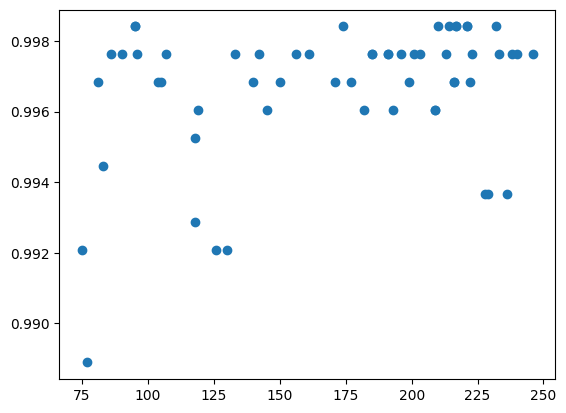

In [166]:
plt.scatter(results_df[(results_df.auc>.96)&(results_df.n_features>70)].n_features, results_df[(results_df.auc>.96)&(results_df.n_features>70)].value, label='auc')

In [167]:
results_df[results_df.value>.998]

,value,odr,auc,n_features,ridge,r_growth,balanced_odr,ok_acc,ng_acc,balanced_threshold,b_soe,b_aer,alg,license_path,onnx
19,0.998413,0.0,0.998413,95,0.041433,0.05,0.0,1.0,0.9683,0.1382,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
20,0.998413,0.0,0.998413,95,0.039426,0.05,0.0,1.0,0.9683,0.1413,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
31,0.998413,0.0,0.998413,174,0.037818,0.05,0.0,1.0,0.9841,0.1879,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
43,0.998413,0.0,0.998413,221,0.044343,0.05,0.0,1.0,0.9841,0.1901,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
55,0.998413,0.0,0.998413,210,0.047983,0.05,0.0,1.0,0.9841,0.1829,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
61,0.998413,0.0,0.998413,217,0.04877,0.05,0.0,1.0,0.9683,0.1870,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
63,0.998413,0.0,0.998413,217,0.04409,0.05,0.0,1.0,0.9683,0.1955,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
65,0.998413,0.0,0.998413,232,0.045659,0.05,0.0,1.0,0.9683,0.2064,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
66,0.998413,0.0,0.998413,214,0.047222,0.05,0.0,1.0,0.9841,0.1885,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx
67,0.998413,0.0,0.998413,221,0.044254,0.05,0.0,1.0,0.9841,0.1903,True,False,PatchSampleDetector,node-locked.lic,wide_resnet50_2-95faca4d.onnx


In [ ]:
# Check
#train 8.919s
#inspect 9.546s
# SDDCXX
#train 34.7
#inspect 16.5

In [11]:
from detectors import SddCxxPSD, PSDParameter

In [48]:
best_params = PSDParameter()
best_params.n_features = 95
best_params.ridge = 0.01
best_params.r_growth = 0.05
best_params.b_soe = True
best_params.b_aer = False
best_params.onnx = '../distfiles/wide_resnet50_2.onnx'
best_params.names = ('356', '398', '460')
best_params.onnx = '../distfiles/resnet18.onnx'
best_params.names = ('140', '156', '172')

In [69]:
'50' in '../distfiles/resnet18.onnx', '50' in '../distfiles/wide_resnet50_2.onnx'

(False, True)

In [49]:
best_params

PSDParameter(alg='PatchSampleDetector', license_path='../license/node-locked.lic', onnx='../distfiles/resnet18.onnx', names=('140', '156', '172'), n_features=95, ridge=0.01, r_growth=0.05, b_soe=True, b_aer=False)

In [50]:
psd = SddCxxPSD(best_params)

In [64]:
st = timer()

psd.fit(bottle_dataset.train_imgs)

et = timer() 
print(et - st)

9.302065900003072


In [63]:
psd.fit(bottle_dataset.train_imgs)
#SddCxx time = 8.9
#Check time = 8.838

In [20]:
anomaly_imgs = psd.predict(bottle_dataset.test_imgs)

In [29]:
len(max_anomalys)

83

In [27]:
max_anomalys = [anomaly_img.max() for anomaly_img in anomaly_imgs]

In [28]:
1+1

2

In [192]:
from ext import (
    SddCxxSensitivity,
    SddCxxRectangleList,
    SddCxxRectangleLists,
    SddCxxLabelList,
    SddCxxAnomalyList,
)

In [193]:
scs = SddCxxSensitivity()
scs.sen.anomaly = 0.1382
scs.sen.area = 100
rects = SddCxxRectangleLists()
labels = SddCxxLabelList()
anomalys = SddCxxAnomalyList()
psd.interpret(
    scs=scs,
    anomaly_imgs=anomaly_imgs,
    rects=rects,
    labels=labels,
    anomalys=anomalys,
)

In [211]:
rects

In [194]:
anomalys

SddCxxAnomalyList[0.190185, 0.195941, 0.199038, 0.205718, 0.254155, 0.190159, 0.255533, 0.214442, 0.218823, 0.257701, 0.194172, 0.22884, 0.186953, 0.193752, 0.205553, 0.245645, 0.206168, 0.237261, 0.191432, 0.227127, 0.186748, 0.216041, 0.21989, 0.212199, 0.211988, 0.185822, 0.210775, 0.1766, 0.191532, 0.234788, 0.236663, 0.214722, 0.212377, 0.249468, 0.232878, 0.207375, 0.224333, 0.228891, 0.180327, 0.220083, 0.195534, 0.170271, 0.15984, 0.182499, 0.19251, 0.155559, 0.134162, 0.209388, 0.249003, 0.19798, 0.168004, 0.226152, 0.244798, 0.153073, 0.136746, 0.151822, 0.153006, 0.1404, 0.147217, 0.189277, 0.170306, 0.238925, 0.188313, 0.106087, 0.106248, 0.112829, 0.100123, 0.112417, 0.0940965, 0.0972648, 0.120493, 0.109803, 0.0984477, 0.113467, 0.103642, 0.107637, 0.137419, 0.0901852, 0.0975869, 0.0887424, 0.132992, 0.106996, 0.092032]

In [203]:
max_anomaly[:5]

[0.19018495082855225,
 0.19594085216522217,
 0.19903767108917236,
 0.2057182788848877,
 0.2541552782058716]

In [217]:
np.mean(anomalys), np.mean(max_anomalys)

(0.17873966263001223, 0.17873966263001223)

In [195]:
labels

SddCxxLabelList[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,  , , , , , , , ,  , , , , , , , , ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ]

In [197]:
criteria_label = [Label(i) for i in bottle_dataset.labels]

In [198]:
from criteria import auc_odr
auc, odr, balanced_metrics, cls_report, confu_mat = auc_odr(anomalys, criteria_label)

In [199]:
auc

0.9984126984126984